In [183]:
import tensorflow as tf
import keras
import pandas as pd
import numpy as np
import os
import sys
import glob
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression

import lightgbm as lgb
# import xgboost as xgb
import time
import datetime
# from catboost import CatBoostRegressor
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import StratifiedKFold, KFold, RepeatedKFold
from sklearn.metrics import mean_absolute_error
from sklearn.linear_model import LinearRegression

from scipy.signal import hilbert
from scipy.signal import hann
from scipy.signal import convolve
from scipy import stats
from sklearn.kernel_ridge import KernelRidge
from tqdm import tqdm_notebook

In [112]:
pd.set_option('display.max_columns', None)

In [113]:
players = pd.read_csv('/home/ryan/ml/tennis_ml/tennis_atp/atp_players.csv', 
                      header=None, 
                      names=['player_id', 'first_name', 'last_name', 'hand', 'birthday','country_code'])

In [114]:
players

,player_id,first_name,last_name,hand,birthday,country_code
0,100001,Gardnar,Mulloy,R,19131122.0,USA
1,100002,Pancho,Segura,R,19210620.0,ECU
2,100003,Frank,Sedgman,R,19271002.0,AUS
3,100004,Giuseppe,Merlo,R,19271011.0,ITA
4,100005,Richard Pancho,Gonzales,R,19280509.0,USA
...,...,...,...,...,...,...
54892,209858,Vladimir,Osminkin,U,NaN,RUS
54893,209859,Rostislav,Galfinger,U,20021112.0,KAZ
54894,209860,Ignacio,Buse,U,20040325.0,PER
54895,209861,Maj,Tomac,U,20010504.0,SLO


In [288]:
df = pd.read_csv('/home/ryan/ml/tennis_ml/tennis_atp/atp_matches_2019.csv')

In [289]:
list(df.columns.values)

['tourney_id',
 'tourney_name',
 'surface',
 'draw_size',
 'tourney_level',
 'tourney_date',
 'match_num',
 'winner_id',
 'winner_seed',
 'winner_entry',
 'winner_name',
 'winner_hand',
 'winner_ht',
 'winner_ioc',
 'winner_age',
 'loser_id',
 'loser_seed',
 'loser_entry',
 'loser_name',
 'loser_hand',
 'loser_ht',
 'loser_ioc',
 'loser_age',
 'score',
 'best_of',
 'round',
 'minutes',
 'w_ace',
 'w_df',
 'w_svpt',
 'w_1stIn',
 'w_1stWon',
 'w_2ndWon',
 'w_SvGms',
 'w_bpSaved',
 'w_bpFaced',
 'l_ace',
 'l_df',
 'l_svpt',
 'l_1stIn',
 'l_1stWon',
 'l_2ndWon',
 'l_SvGms',
 'l_bpSaved',
 'l_bpFaced',
 'winner_rank',
 'winner_rank_points',
 'loser_rank',
 'loser_rank_points']

In [290]:
#unique ids in the csv
ids = pd.concat([df['winner_id'], df['loser_id']]).unique()
ids

array([105453, 106421, 104542, 104871, 200282, 105683, 106034, 105777,
       111442, 104918, 200175, 106401, 105357, 106045, 105138, 104607,
       104925, 106065, 105932, 104527, 105583, 105732, 105916, 126094,
       111797, 104198, 105575, 105550, 104269, 109739, 104731, 103333,
       104468, 104327, 144719, 105332, 104291, 105208, 111513, 104620,
       125802, 106210, 111581, 106368, 105539, 105815, 111815, 105526,
       104259, 126203, 105807, 104919, 104926, 105311, 103970, 104907,
       126610, 200005, 105376, 104312, 106043, 126774, 106415, 105819,
       105373, 105023, 124187, 106121, 133430, 105676, 105657, 105992,
       100644, 106109, 111202, 106432, 105936, 106298, 200615, 106233,
       105227, 111456, 105430, 111575, 104678, 105882, 104792, 105554,
       103819, 126207, 104655, 105341, 104898, 105967, 105051, 104745,
       106228, 105643, 105379, 106398, 105561, 105077, 132283, 106148,
       104571, 126156, 104719, 120424, 104978, 105062, 106426, 111790,
      

In [ ]:
###iterate through player ids and collect features

#instantiate a new dictionary to keep track of player stats
#this will be useful for diffing them later to create input-target pairs
pid_dict = {}
    
for target_pid in tqdm_notebook(ids):
    ### get features from whether the target player won or lost
    df2 = df[(df.loc[:,'winner_id'] == target_pid ) | (df.loc[:,'loser_id'] == target_pid)]

    ###create target column here
    y = [1 if pid==target_pid else 0 for pid in df2.winner_id.values]
    y = pd.DataFrame(data=y, columns=['target'])

    ###switch up the dataframe to account for losses since after 
    ###taking target into account, we dont care about winner/loser specific columns
    # swapped_features = ['ace', 'df', 'svpt', '1stIn', '1stWon', '2ndWon', 'SvGms', 'bpSaved', 'bpFaced']
    swapped_features = ['ace', 'df']
    for swapFeat in swapped_features:
        df2.loc[(y.target.values == 0), f'w_{swapFeat}'] = df2.loc[(y.target.values == 0), f'l_{swapFeat}']

    ### sort by tournament date and match number so features are sequential/time-dependant
    df2 = df2.sort_values(['tourney_date', 'match_num'], ascending=[True, True])

    ###extract stats from features
    segments = df2.shape[0]
    # features = ['w_ace', 'w_df', 'w_svpt', 'w_1stIn', 'w_1stWon', 'w_2ndWon', 'w_SvGms', 'w_bpSaved', 'w_bpFaced']
    features = ['w_ace', 'w_df']
    x_tr = extract_stats(df2, segments, features)

    df2.reset_index(drop=True, inplace=True)
    x_tr.reset_index(drop=True, inplace=True)
    y.reset_index(drop=True, inplace=True)

    x_tr = pd.concat([df2['tourney_date'], df2['match_num'], y['target'], x_tr], axis=1)

    # ### save to dictionary by PID
    pid_dict.update({f'{target_pid}' : x_tr})

/home/ryan/.conda/envs/tf-gpu/lib/python3.7/site-packages/ipykernel_launcher.py:56: RuntimeWarning: Mean of empty slice.
/home/ryan/.conda/envs/tf-gpu/lib/python3.7/site-packages/ipykernel_launcher.py:61: RuntimeWarning: Mean of empty slice.
/home/ryan/.conda/envs/tf-gpu/lib/python3.7/site-packages/ipykernel_launcher.py:59: RuntimeWarning: divide by zero encountered in true_divide
/home/ryan/.conda/envs/tf-gpu/lib/python3.7/site-packages/ipykernel_launcher.py:64: RuntimeWarning: divide by zero encountered in true_divide
/home/ryan/.conda/envs/tf-gpu/lib/python3.7/site-packages/ipykernel_launcher.py:59: RuntimeWarning: invalid value encountered in true_divide


In [ ]:
len(pid_dict)

In [226]:
### now iterate throught the main dataframe to link up player-ids
### and pull information from the respective dictionary index to form input-target pairs
x_data = np.empty(shape=(int(df.shape[0]*2), 31))
y_data = np.empty(shape=(int(df.shape[0]*2), 1))
print(x_data.shape)

### get features from whether the target player won or lost
df = df.sort_values(['tourney_date', 'match_num'], ascending=[True, True])

j = 0

for winner_id, loser_id, tdate, match_num in tqdm_notebook(zip(df.winner_id.values, df.loser_id.values, df.tourney_date.values, df.match_num.values)):

    #extract features from player maps
    features_w = np.asarray(pid_dict[f'{winner_id}'].loc[(pid_dict[f'{winner_id}']['tourney_date'] == tdate) & (pid_dict[f'{winner_id}']['match_num'] == match_num)].loc[:, 'ace_mean':])
    features_l = np.asarray(pid_dict[f'{loser_id}'].loc[(pid_dict[f'{loser_id}']['tourney_date'] == tdate) & (pid_dict[f'{loser_id}']['match_num'] == match_num)].loc[:, 'ace_mean':])

    #diff the features from winner to loser and count as a win
    x_data[j,:] = features_w - features_l
    y_data[j,0] = 1.0
    
    #diff the features from loser to winner and count as a loss
    x_data[j+1,:] = features_l - features_w
    y_data[j+1,0] = 0.0
        
    #increment counter
    j+=2
    
    
    

(5562, 31)


In [227]:
x_data.shape

(5562, 31)

In [293]:
def extract_stats(df, segments, features):

    #main dataframe for storing stats
    X_tr = pd.DataFrame(index=range(segments), dtype=np.float64)
    
    for feature in features:
    
        #time series data
        x_full = pd.Series(df[f'{feature}'].values)
        feature_name = feature[2:]
    
        for segment in range(segments):
            #take all of x until that point in time
            x = x_full[:segment+1]
            
            #compute stats on this feature
            X_tr.loc[segment, f'{feature_name}_mean'] = x.mean()
            X_tr.loc[segment, f'{feature_name}_std'] = x.std()
            X_tr.loc[segment, f'{feature_name}_max'] = x.max()
            X_tr.loc[segment, f'{feature_name}_min'] = x.min()

            X_tr.loc[segment, f'{feature_name}_mean_change_abs'] = np.mean(np.diff(x))
            X_tr.loc[segment, f'{feature_name}_abs_max'] = np.abs(x).max()
            X_tr.loc[segment, f'{feature_name}_abs_min'] = np.abs(x).min()

            X_tr.loc[segment, 'max_to_min_diff'] = x.max() - np.abs(x.min())
            X_tr.loc[segment, 'sum'] = x.sum()

            X_tr.loc[segment, 'q95'] = np.quantile(x, 0.95)
            X_tr.loc[segment, 'q99'] = np.quantile(x, 0.99)
            X_tr.loc[segment, 'q05'] = np.quantile(x, 0.05)
            X_tr.loc[segment, 'q01'] = np.quantile(x, 0.01)

#             X_tr.loc[segment, 'abs_q95'] = np.quantile(np.abs(x), 0.95)
#             X_tr.loc[segment, 'abs_q99'] = np.quantile(np.abs(x), 0.99)
#             X_tr.loc[segment, 'abs_q05'] = np.quantile(np.abs(x), 0.05)
#             X_tr.loc[segment, 'abs_q01'] = np.quantile(np.abs(x), 0.01)

#########################
        #     X_tr.loc[segment, 'trend'] = add_trend_feature(x)
        #     X_tr.loc[segment, 'abs_trend'] = add_trend_feature(x, abs_values=True)
        #     X_tr.loc[segment, 'abs_mean'] = np.abs(x).mean()
        #     X_tr.loc[segment, 'abs_std'] = np.abs(x).std()
#######################
#             X_tr.loc[segment, 'mad'] = x.mad()
#             X_tr.loc[segment, 'kurt'] = x.kurtosis()
#             X_tr.loc[segment, 'skew'] = x.skew()
#             X_tr.loc[segment, 'med'] = x.median()

            #rolling stats
#             for windows in [2, 4, 6, 8, 10, 12, 14, 16, 20, 25]:
            for windows in [2, 4, 6]:
                x_roll_std = x.rolling(windows).std().dropna().values
                x_roll_mean = x.rolling(windows).mean().dropna().values

                X_tr.loc[segment, f'{feature_name}_ave_roll_std_' + str(windows)] = x_roll_std.mean()
                X_tr.loc[segment, f'{feature_name}_std_roll_std_' + str(windows)] = x_roll_std.std()
                X_tr.loc[segment, f'{feature_name}_av_change_abs_roll_std_' + str(windows)] = np.mean(np.diff(x_roll_std))
                X_tr.loc[segment, f'{feature_name}_av_change_rate_roll_std_' + str(windows)] = np.mean(np.nonzero((np.diff(x_roll_std) / x_roll_std[:-1]))[0])

                X_tr.loc[segment, f'{feature_name}_ave_roll_mean_' + str(windows)] = x_roll_mean.mean()
                X_tr.loc[segment, f'{feature_name}_std_roll_mean_' + str(windows)] = x_roll_mean.std()
                X_tr.loc[segment, f'{feature_name}_av_change_abs_roll_mean_' + str(windows)] = np.mean(np.diff(x_roll_mean))
                X_tr.loc[segment, f'{feature_name}_av_change_rate_roll_mean_' + str(windows)] = np.mean(np.nonzero((np.diff(x_roll_mean) / x_roll_mean[:-1]))[0])
                
    #fill all NaN values with 0
    X_tr = X_tr.fillna(value=0.0)
    
    return X_tr

## LGB Model developement

In [ ]:
# using LGBM lib here
# link to original work: https://papers.nips.cc/paper/6907-lightgbm-a-highly-efficient-gradient-boosting-decision-tree.pdf

In [282]:
from sklearn.model_selection import train_test_split

from sklearn import svm, datasets
from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import label_binarize
from sklearn.multiclass import OneVsRestClassifier
from scipy import interp
from sklearn.metrics import roc_auc_score, accuracy_score

In [241]:
X_train, X_test, y_train, y_test = train_test_split(x_data, y_data, test_size=0.33, random_state=7)

In [284]:
params = {'num_leaves': 128,
          'min_data_in_leaf': 79,
          'max_depth': -1,
          'learning_rate': 0.001,
          "boosting": "gbdt",
          "bagging_freq": 5,
          "bagging_fraction": 0.8126672064208567,
          "bagging_seed": 11,
          "verbosity": -1,
          'reg_alpha': 0.1302650970728192,
          'reg_lambda': 0.3603427518866501}

model = lgb.LGBMClassifier(**params,
                           n_estimators = 100,
                           n_jobs = -1, 
                           objective='binary')

#fit on the k-fold
model.fit(X_train, y_train[:,0],
          eval_set=[(X_train, y_train), (X_test, y_test)],
          verbose=True)

/home/ryan/.conda/envs/tf-gpu/lib/python3.7/site-packages/sklearn/preprocessing/label.py:252: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[1]	valid_0's binary_logloss: 0.692877	valid_1's binary_logloss: 0.693928
[2]	valid_0's binary_logloss: 0.692774	valid_1's binary_logloss: 0.693868
[3]	valid_0's binary_logloss: 0.692671	valid_1's binary_logloss: 0.693808
[4]	valid_0's binary_logloss: 0.692569	valid_1's binary_logloss: 0.693747
[5]	valid_0's binary_logloss: 0.692466	valid_1's binary_logloss: 0.693686
[6]	valid_0's binary_logloss: 0.692365	valid_1's binary_logloss: 0.693626
[7]	valid_0's binary_logloss: 0.692265	valid_1's binary_logloss: 0.693566
[8]	valid_0's binary_logloss: 0.692164	valid_1's binary_logloss: 0.693507
[9]	valid_0's binary_logloss: 0.692064	valid_1's binary_logloss: 0.693447
[10]	valid_0's binary_logloss: 0.691964	valid_1's binary_logloss: 0.693389
[11]	valid_0's binary_logloss: 0.691855	valid_1's binary_logloss: 0.693343
[12]	valid_0's binary_logloss: 0.691746	valid_1's binary_logloss: 0.693297
[13]	valid_0's binary_logloss: 0.691637	valid_1's binary_logloss: 0.693251
[14]	valid_0's binary_logloss: 0.6

LGBMClassifier(bagging_fraction=0.8126672064208567, bagging_freq=5,
               bagging_seed=11, boosting='gbdt', boosting_type='gbdt',
               class_weight=None, colsample_bytree=1.0, importance_type='split',
               learning_rate=0.001, max_depth=-1, min_child_samples=20,
               min_child_weight=0.001, min_data_in_leaf=79, min_split_gain=0.0,
               n_estimators=100, n_jobs=-1, num_leaves=128, objective='binary',
               random_state=None, reg_alpha=0.1302650970728192,
               reg_lambda=0.3603427518866501, silent=True, subsample=1.0,
               subsample_for_bin=200000, subsample_freq=0, verbosity=-1)

In [285]:
y_pred = np.expand_dims(model.predict(X_test), -1)

In [286]:
print(accuracy_score(y_test, y_pred))

0.5626361655773421


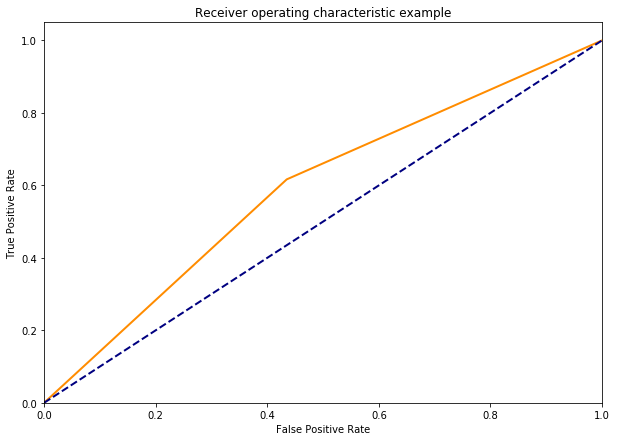

In [281]:
# Compute ROC curve and ROC area for each class
fpr, tpr, _ = roc_curve(y_test[:, 0], y_pred[:, 0])
roc_auc = auc(fpr, tpr)

# Compute micro-average ROC curve and ROC area
# fpr["micro"], tpr["micro"], _ = roc_curve(y_test.ravel(), y_pred.ravel())
# roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

plt.figure(figsize=(10,7))
lw = 2
plt.plot(fpr, tpr, color='darkorange',lw=lw)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.show()

In [ ]:
n_fold = 5
folds = KFold(n_splits=n_fold, shuffle=True, random_state=11)

In [ ]:
def train_model(X=X_train_scaled, X_test=X_test_scaled, y=y_tr, params=None, folds=folds, model_type='lgb', plot_feature_importance=False, model=None):

    oof = np.zeros(len(X))
    prediction = np.zeros(len(X_test))
    scores = []
    feature_importance = pd.DataFrame()
    
    #begin k-fold cross validation
    for fold_n, (train_index, valid_index) in enumerate(folds.split(X)):
        print('Fold', fold_n, 'started at', time.ctime())
        X_train, X_valid = X.iloc[train_index], X.iloc[valid_index]
        y_train, y_valid = y.iloc[train_index], y.iloc[valid_index]
        
        #instantiate model
        model = lgb.LGBMRegressor(**params,
                                  n_estimators = 50000,
                                  n_jobs = -1)
        
        #fit on the k-fold
        model.fit(X_train, y_train,
                  eval_set=[(X_train, y_train), (X_valid, y_valid)],
                  eval_metric='mae',
                  verbose=10000,
                  early_stopping_rounds=200)
        
        #run inference on validation data
        y_pred_valid = model.predict(X_valid)
        
        #run inference on hold-out test dataset
        y_pred = model.predict(X_test, 
                               num_iteration=model.best_iteration_)
                    
        oof[valid_index] = y_pred_valid.reshape(-1,)
        scores.append(mean_absolute_error(y_valid, y_pred_valid))

        prediction += y_pred    
        
        # feature importance
        fold_importance = pd.DataFrame()
        fold_importance["feature"] = X.columns
        fold_importance["importance"] = model.feature_importances_
        fold_importance["fold"] = fold_n + 1
        feature_importance = pd.concat([feature_importance, fold_importance], axis=0)

        
    prediction /= n_fold
    
    print('CV mean score: {0:.4f}, std: {1:.4f}.'.format(np.mean(scores), np.std(scores)))
        
    #plot feature importance
    feature_importance["importance"] /= n_fold
    if plot_feature_importance:
        cols = feature_importance[["feature", "importance"]].groupby("feature").mean().sort_values(
            by="importance", ascending=False)[:50].index

        best_features = feature_importance.loc[feature_importance.feature.isin(cols)]

        plt.figure(figsize=(16, 12));
        sns.barplot(x="importance", y="feature", data=best_features.sort_values(by="importance", ascending=False));
        plt.title('LGB Features (avg over folds)');

        return oof, prediction, feature_importance
    
    return oof, prediction

In [ ]:
params = {'num_leaves': 128,
          'min_data_in_leaf': 79,
          'objective': 'huber',
          'max_depth': -1,
          'learning_rate': 0.01,
          "boosting": "gbdt",
          "bagging_freq": 5,
          "bagging_fraction": 0.8126672064208567,
          "bagging_seed": 11,
          "metric": 'mae',
          "verbosity": -1,
          'reg_alpha': 0.1302650970728192,
          'reg_lambda': 0.3603427518866501}

oof_lgb, prediction_lgb, feature_importance = train_model(params=params, 
                                                          model_type='lgb',
                                                          plot_feature_importance=True)

In [ ]:
top_cols = list(feature_importance[["feature", "importance"]].groupby("feature").mean().sort_values(
                by="importance", ascending=False)[:50].index)

In [ ]:
# Taking less columns seriously decreases score.
X_train_scaled = X_train_scaled[top_cols]
X_test_scaled = X_test_scaled[top_cols]

oof_lgb, prediction_lgb, feature_importance = train_model(X=X_train_scaled, 
                                                          X_test=X_test_scaled, 
                                                          params=params, 
                                                          model_type='lgb',
                                                          plot_feature_importance=True)

## Evaluation

## Real match prediction